[0, 4, 5, 1, 5, 1, 5, 0, 1, 5, 4, 0, 0, 4, 0, 5, 4, 0, 1, 0, 1, 0, 1, 5, 4, 5, 0, 4, 1, 0, 5, 1, 0, 1, 5, 1, 0, 1, 0, 4, 0, 1, 0, 4, 4, 5, 1, 1, 5, 4, 0, 1, 0, 4, 0, 1, 4, 5, 5, 1, 0, 1, 5, 4, 0, 4, 0, 0, 1, 0, 1, 5, 1, 4, 0, 4, 5, 4, 0, 0, 4, 5, 4, 0, 1, 4, 5]
[4, 5, 1, 5, 1, 0, 4, 1, 5, 4, 5, 1, 4, 0, 1, 4, 0, 1, 5, 1, 5, 1, 5, 4, 5, 1, 4, 5, 0, 4, 1, 0, 1, 5, 1, 0, 4, 0, 4, 0, 1, 0, 4, 4, 5, 1, 1, 5, 4, 5, 1, 5, 4, 0, 1, 5, 5, 1, 1, 0, 1, 5, 1, 0, 1, 0, 1, 1, 5, 1, 5, 4, 5, 5, 4, 5, 4, 0, 1, 4, 5, 4, 0, 1, 5, 5, 1]


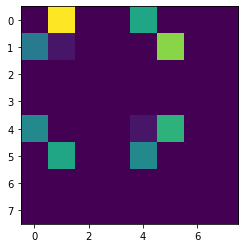

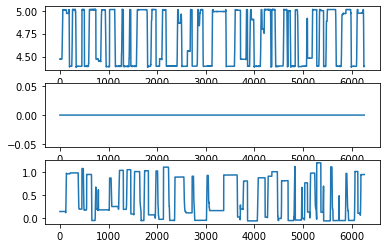

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import copy
import matplotlib
%matplotlib inline
sys.path.append("..")
from demo_2_awac import och_2_awac
import adept_envs
import gym

# Load in the data
all_paths = 'demo_list_hardware_cabinet_slider_relabeled_dense.pkl'

paths = pickle.load(open(all_paths, 'rb'))
import itertools

def check_goal_completion(curr_pos):
    max_objs = np.array([4.8, 4.4, 0.7])
    min_objs = np.array([4.5, 3.6, 0.4])
    init_bitflips = np.array([0, 0, 0])
    curr_bitflips = init_bitflips.copy()
    if len(curr_pos.shape) > 1:
        curr_pos = curr_pos.squeeze(axis=0)
    for j in range(3):
        if curr_pos[j] > max_objs[j]:
            curr_bitflips[j] = 1
        elif curr_pos[j] < min_objs[j]:
            curr_bitflips[j] = 0
    new_idx = 4 * curr_bitflips[0] + 2 * curr_bitflips[1] + curr_bitflips[2]
    return new_idx

input_x = []
for path in paths:
    input_x.append(path['observations'][:-30])
input_x = np.concatenate(input_x, axis=0)[:, :3]

input_x[:, 1] = 0.
input_y = []
start_idxs = []
end_idxs = []
# Get labels
for path in paths:
    for i in range(len(path['observations']) - 30):
        next_idx = check_goal_completion(path['observations'][-1, :3])
        input_y.append(next_idx)
        
    next_idx = check_goal_completion(path['observations'][0, :3])
    start_idxs.append(next_idx)
    next_idx = check_goal_completion(path['observations'][-1, :3])
    end_idxs.append(next_idx)
    
input_y = np.asarray(input_y)

print(start_idxs)
print(end_idxs)
adjacency_matrix = np.zeros((8,8))
for s, e in zip(start_idxs, end_idxs):
    adjacency_matrix[s, e] += 1


import matplotlib.pyplot as plt
plt.imshow(adjacency_matrix)
plt.show()

fig, ax = plt.subplots(3,1)
for i in range(3):
    ax[i].plot(input_x[:, i])

In [2]:
from torch.utils.data import TensorDataset, DataLoader
from rlkit.torch.networks import ConcatMlp, Mlp
import torch
import torch.nn as nn
input_size = 3
num_goals = 8
batch_size = 32


goal_predictor = Mlp(
    input_size=input_size,
    output_size=num_goals,
    hidden_sizes=(256, 256, 256),
)

optimizer = torch.optim.Adam(goal_predictor.parameters())

idxs_data = np.array(range(len(input_x)))
np.random.shuffle(idxs_data)
num_train = int(0.9*len(idxs_data))

input_x_train = input_x[idxs_data[:num_train]]
input_x_test = input_x[idxs_data[num_train:]]

input_y_train = input_y[idxs_data[:num_train]]
input_y_test = input_y[idxs_data[num_train:]]

# TODO: Check the syntax
train_ds = TensorDataset(torch.Tensor(input_x_train), torch.Tensor(input_y_train).long())
test_ds = TensorDataset(torch.Tensor(input_x_test), torch.Tensor(input_y_test).long())

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()

In [6]:
num_epochs = 10
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = goal_predictor(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.8f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            outputs = goal_predictor(torch.Tensor(input_x_test))
            accuracy = np.sum(np.argmax(outputs.detach().numpy(), axis=1) == np.array(input_y_test, dtype=np.int32))/len(input_x_test)
            print('TEST %f \n'%accuracy*100)
            

print('Finished Training')

TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356230 
TEST 0.356

TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445687 
TEST 0.445

TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466454 
TEST 0.466

TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476038 
TEST 0.476

In [7]:
for p in paths:
    o = p['observations'][0, :3]
    o[1] = 0.
    o = torch.Tensor(o)
    prediction = torch.nn.Softmax()(goal_predictor(o)).detach().numpy()
    print(prediction)
    print("START_IDX " + str(check_goal_completion(p['observations'][0, :3])))
    print("END_IDX " + str(check_goal_completion(p['observations'][-1, :3])))

[1.7920870e-01 5.4962778e-01 4.9876480e-08 4.9193865e-08 2.6930907e-01
 1.8541262e-03 4.9626337e-08 4.9398366e-08]
START_IDX 0
END_IDX 4
[2.3769073e-01 8.6439023e-04 6.6801958e-10 6.6207301e-10 3.5629961e-01
 4.0514529e-01 6.4826872e-10 6.6899120e-10]
START_IDX 4
END_IDX 5
[2.3574480e-03 5.2173096e-01 9.5993937e-07 9.5568828e-07 1.8474695e-01
 2.9116097e-01 9.1843327e-07 9.4606600e-07]
START_IDX 5
END_IDX 1
[1.4918378e-01 3.5743317e-01 8.4660105e-06 8.3737004e-06 2.9449032e-03
 4.9040455e-01 8.2488641e-06 8.4117992e-06]
START_IDX 1
END_IDX 5
[1.9562826e-03 5.2279997e-01 6.7236596e-07 6.6949116e-07 1.8963400e-01
 2.8560707e-01 6.4243574e-07 6.6259247e-07]
START_IDX 5
END_IDX 1
[1.4918378e-01 3.5743317e-01 8.4660105e-06 8.3737004e-06 2.9449032e-03
 4.9040455e-01 8.2488641e-06 8.4117992e-06]
START_IDX 1
END_IDX 0
[1.4206651e-03 5.3837562e-01 2.5669729e-07 2.5541868e-07 1.6746384e-01
 2.9273885e-01 2.4433660e-07 2.5249545e-07]
START_IDX 5
END_IDX 4
[2.5640836e-01 6.1156297e-01 1.6569363e-0

/usr/local/google/home/abhishekunique/anaconda3/envs/softlearning-sim-new/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [ ]:
torch.save(goal_predictor, 'test_model_save.pkl')

In [ ]:
dat = torch.load('test_model_save.pkl')

In [ ]:
goal_predictor.load_state_dict(dat.state_dict())